In [38]:
import ast
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from mlxtend.plotting import plot_decision_regions

import numpy as np

import pandas as pd
# pd.options.display.max_columns = None
# pd.set_option('display.max_rows', 500)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import seaborn as sns

import re

from sklearn import datasets
from sklearn.datasets import( load_iris, load_digits, fetch_lfw_people )
from sklearn.ensemble import( AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, 
                              GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor, StackingClassifier )

from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import( KNNImputer, SimpleImputer )
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import( LogisticRegression, LinearRegression, Ridge, Lasso )
from sklearn.model_selection import( cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split )
from sklearn.metrics import( accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, mean_squared_error,plot_confusion_matrix, r2_score, RocCurveDisplay, )
                             
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import ( DecisionTreeClassifier, DecisionTreeRegressor )
from sklearn.utils import resample

from scipy.stats import mode 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings( "ignore", category=DeprecationWarning ) # to avoid deprecation warnings

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template( layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6",
                                                              "#2A7FAF", "#23B1AB", "#0E3449", "#015955"] )
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JUPITER or "iframe_connected" or "notebook"

from xgboost import XGBRegressor


In [39]:
dataset = pd.read_csv('src/conversion_data_train.csv')

In [40]:
dataset['new_user'] =  dataset['new_user'].astype(str)
dataset['new_user'] = [ 'Yes' if x == '1' else 'No' for x in dataset['new_user'] ]

## Séparation Variables explicative X et variable Cible/Target Y 

In [41]:
target_name = 'converted'

Y = dataset[:][target_name]
X = dataset.drop(columns= [target_name])

## Séparation en Entrainement & Test 

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Préprocessing Pipeline

In [43]:
# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur

print(f'numeric_features : {numeric_features}')
print(f'categorical_features : {categorical_features}')

numeric_features : Index(['age', 'total_pages_visited'], dtype='object')
categorical_features : Index(['country', 'new_user', 'source'], dtype='object')


## Training Model
### Random Forest model : Grid search

In [44]:
model = RandomForestClassifier()
# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(model, param_grid = params, cv = 5, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [45]:
print(gridsearch.best_estimator_)
print(gridsearch.best_score_, gridsearch.best_params_)

RandomForestClassifier(max_depth=8, n_estimators=40)
0.9860188706456409 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}


In [52]:
Y_pred= gridsearch.predict(X_test)

print(f1_score(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

0.7489309712889433
0.9855576639257854


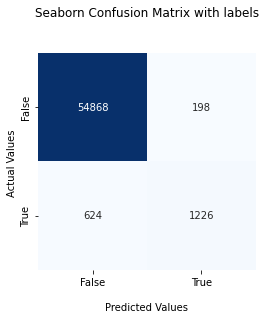

In [63]:
matrix_confusion = confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

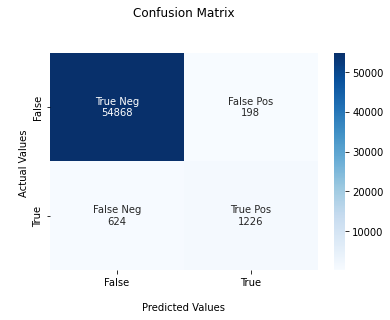

In [67]:
# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

matrix_confusion = confusion_matrix(Y_test, Y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix_confusion.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(matrix_confusion, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()